## Explore the relationship between metacritic score and the current features to find what features to encode or engineer

In [1]:
%config InlineBackend.figure_formats = ['retina']

import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import category_encoders as ce

In [2]:
oscars_df = pd.read_csv('oscar_movies_data.csv',index_col=0 )

In [3]:
oscars_df.describe()

,runtime (mins),metacritic score,budget,Total_Noms,Award_Year
count,3303.000000,3303.000000,3.223000e+03,3303.000000,3291.000000
mean,127.243112,76.183470,4.504520e+07,5.398728,2000.761167
std,23.834388,12.732737,4.926863e+07,3.500535,11.731420
min,70.000000,16.000000,6.500000e+04,1.000000,1980.000000
25%,111.000000,68.000000,1.400000e+07,2.000000,1990.500000
50%,124.000000,78.000000,2.700000e+07,5.000000,2002.000000
75%,139.000000,86.000000,5.500000e+07,8.000000,2011.000000
max,224.000000,100.000000,3.210000e+08,16.000000,2020.000000


In [4]:
oscars_df.shape

(3303, 23)

## Create dummies for awards

In [5]:
top_ten = oscars_df['Awards'].value_counts().iloc[:10]
mask = oscars_df['Awards'].isin(top_ten.index)

In [6]:
oscars_df['Awards'][mask].value_counts()

Best Picture                         122
Best Director                        122
Best Motion Picture of the Year      121
Best Film Editing                    115
Best Actor in a Supporting Role      113
Best Actor in a Leading Role         113
Best Art Direction-Set Decoration    107
Best Cinematography                  105
Best Sound                           102
Best Actress in a Leading Role       102
Name: Awards, dtype: int64

In [7]:
top_awards= oscars_df['Awards'][mask]

In [8]:
awards_dummies = pd.get_dummies(oscars_df['Awards'][mask],prefix='Awards')

In [9]:
oscars_df = pd.concat([oscars_df, awards_dummies], axis=1)

## Drop duplicates and sort by release date

In [10]:
oscars_df.drop_duplicates(subset=['IMDBId'],inplace=True)

In [11]:
oscars_df.sort_values(by='release_date',inplace=True)

## Create some numeric columns around metacritic score
#### Get a directors average
* To avoid the initial data leakage I am taking a rolling mean to get the average score of the director overtime

In [12]:
oscars_df['Dir_Prev_Score'] = oscars_df.groupby('director')['metacritic score'].shift(1)

In [13]:
oscars_df[oscars_df['director']=='Martin Scorsese'][['release_date','metacritic score','Dir_Prev_Score']]

,release_date,metacritic score,Dir_Prev_Score
1875,1980-12-19,89.0,NaN
1566,1986-10-17,77.0,89.0
617,1988-09-09,80.0,77.0
2513,1990-09-21,90.0,80.0
2630,1991-11-15,73.0,90.0
79,1993-10-01,90.0,73.0
2195,1995-11-22,73.0,90.0
3084,1998-01-16,74.0,73.0
1398,2002-12-20,72.0,74.0
215,2004-12-25,77.0,72.0


In [14]:
oscars_df['Director_Avg_Score'] = oscars_df.groupby('director')['Dir_Prev_Score'].rolling(2).mean().reset_index(0,drop=True)

In [15]:
oscars_df[oscars_df['director']=='Martin Scorsese'][['release_date','metacritic score','Dir_Prev_Score','Director_Avg_Score']]

,release_date,metacritic score,Dir_Prev_Score,Director_Avg_Score
1875,1980-12-19,89.0,NaN,NaN
1566,1986-10-17,77.0,89.0,NaN
617,1988-09-09,80.0,77.0,83.0
2513,1990-09-21,90.0,80.0,78.5
2630,1991-11-15,73.0,90.0,85.0
79,1993-10-01,90.0,73.0,81.5
2195,1995-11-22,73.0,90.0,81.5
3084,1998-01-16,74.0,73.0,81.5
1398,2002-12-20,72.0,74.0,73.5
215,2004-12-25,77.0,72.0,73.0


In [16]:
oscars_df.Director_Avg_Score.fillna(oscars_df.Dir_Prev_Score, inplace=True)

In [17]:
oscars_df.Director_Avg_Score.fillna(oscars_df['Director_Avg_Score'].mean(), inplace=True)

In [18]:
oscars_df.tail()

,IMDBId,movie title,language,country,runtime (mins),mpaarating,metacritic score,budget,distributionCompany,Awards,...,Awards_Best Actress in a Leading Role,Awards_Best Art Direction-Set Decoration,Awards_Best Cinematography,Awards_Best Director,Awards_Best Film Editing,Awards_Best Motion Picture of the Year,Awards_Best Picture,Awards_Best Sound,Dir_Prev_Score,Director_Avg_Score
3155,tt0373175,My Architect,English,USA,116,Unrated,81.0,NaN,New Yorker Films,"Best Documentary, Features",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.607075
3207,tt3652526,Fire at Sea,Italian,Italy,114,Unrated,87.0,NaN,Kino Lorber,Best Documentary Feature,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.607075
3331,tt0424024,Darwin's Nightmare,English,Austria,107,Unrated,84.0,NaN,International Film Circuit,"Best Documentary, Features",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.607075
3355,tt0240885,Scottsboro: An American Tragedy,English,USA,84,Unrated,74.0,NaN,Public Broadcasting Service,"Best Documentary, Features",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.607075
3362,tt1787725,If a Tree Falls: A Story of the Earth Liberati...,English,USA,85,Unrated,65.0,4800000.0,Oscilloscope,"Best Documentary, Features",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.607075


* Get the rolling count of a movies directed by a director

In [19]:
oscars_df['Dir_Prev_Movie']=oscars_df.groupby(['director'])['movie title'].shift(1)
oscars_df['Total_Directed_Movies'] =  oscars_df.groupby('director')['Dir_Prev_Movie'].expanding().count().reset_index(0,drop=True)

In [20]:
oscars_df.Total_Directed_Movies.value_counts()

0.0     613
1.0     219
2.0     117
3.0      62
4.0      37
5.0      27
6.0      13
7.0      10
8.0       9
9.0       7
10.0      7
11.0      4
12.0      2
13.0      2
14.0      2
18.0      1
15.0      1
16.0      1
17.0      1
19.0      1
Name: Total_Directed_Movies, dtype: int64

In [21]:
top_ten = oscars_df['director'].value_counts().iloc[:10]
mask = oscars_df['director'].isin(top_ten.index)

In [22]:
top_directors = oscars_df['director'][mask]

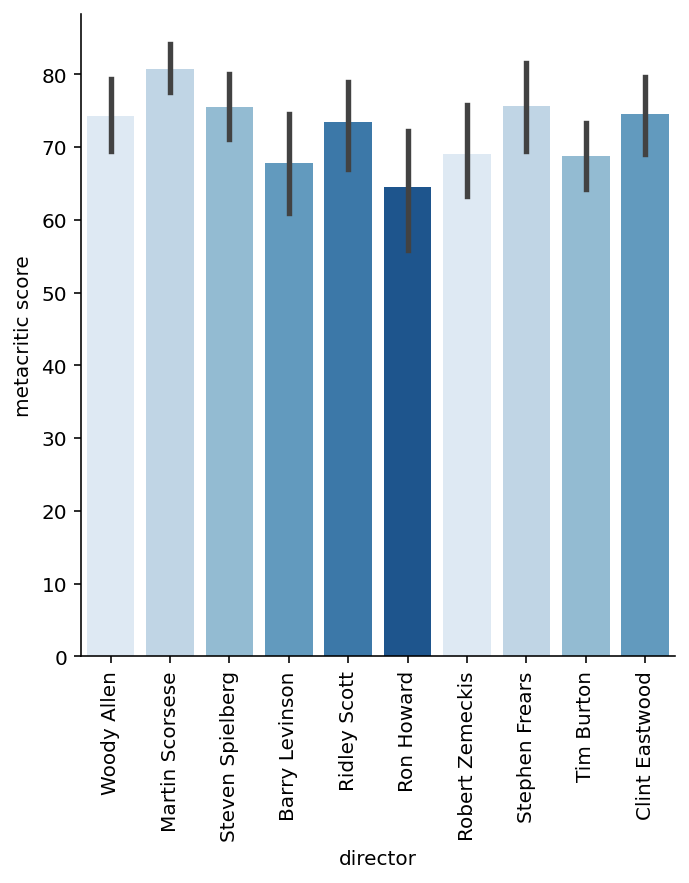

In [23]:
sns.catplot(data=oscars_df, kind="bar", x=top_directors, y="metacritic score",palette = sns.color_palette('Blues'))
plt.xticks(rotation=90);

In [24]:
plt.savefig('director_cat_plot.jpg', dpi=400)

<Figure size 432x288 with 0 Axes>

### Lead actors average score
* Get the rolling average of an actor over time

In [25]:
oscars_df.groupby('Lead_Actor')['metacritic score'].mean()

Lead_Actor
"Auli'i Cravalho"                    81.0
"Elizabeth 'Eliza' Maganga Nsese"    84.0
"Jack O'Connell"                     59.0
"Latrenda 'Boosie' Ash"              85.0
"O'Shea Jackson Jr."                 72.0
                                     ... 
Yun-Fat Chow                         82.0
Zachary Quinto                       76.0
Zaide Silvia Gutiérrez               67.0
Zain Al Rafeea                       75.0
Ziyi Zhang                           89.0
Name: metacritic score, Length: 645, dtype: float64

In [26]:
oscars_df['Lead_Actor_Prev_Score'] = oscars_df.groupby('Lead_Actor')['metacritic score'].shift(1)

In [27]:
oscars_df['Lead_Actor_Avg_Score'] = oscars_df.groupby('Lead_Actor')['Lead_Actor_Prev_Score'].rolling(2).mean().reset_index(0,drop=True)

In [28]:
oscars_df.Lead_Actor_Avg_Score.fillna(oscars_df.Lead_Actor_Prev_Score, inplace=True)

In [29]:
oscars_df.Lead_Actor_Avg_Score.fillna(oscars_df.Lead_Actor_Avg_Score.mean(),inplace=True)

In [30]:
oscars_df.sort_values('Lead_Actor_Avg_Score',ascending=False)

,IMDBId,movie title,language,country,runtime (mins),mpaarating,metacritic score,budget,distributionCompany,Awards,...,Awards_Best Film Editing,Awards_Best Motion Picture of the Year,Awards_Best Picture,Awards_Best Sound,Dir_Prev_Score,Director_Avg_Score,Dir_Prev_Movie,Total_Directed_Movies,Lead_Actor_Prev_Score,Lead_Actor_Avg_Score
2742,tt0104691,The Last of the Mohicans,English,USA,112,R,76.0,40000000.0,Twentieth Century Fox,Best Sound,...,0.0,0.0,0.0,1.0,NaN,73.607075,NaN,0.0,97.0,97.0
3120,tt4209788,Molly's Game,English,China,140,R,71.0,30000000.0,STX Entertainment,Best Adapted Screenplay,...,NaN,NaN,NaN,NaN,NaN,73.607075,NaN,0.0,95.0,95.0
3117,tt0473444,Curse of the Golden Flower,Mandarin,China,114,R,70.0,45000000.0,Sony Pictures Classics,Best Achievement in Costume Design,...,NaN,NaN,NaN,NaN,89.0,87.000000,House of Flying Daggers,2.0,94.0,94.0
2130,tt0114287,Rob Roy,English,UK,139,R,55.0,28000000.0,United Artists,Best Actor in a Supporting Role,...,0.0,0.0,0.0,0.0,NaN,73.607075,NaN,0.0,94.0,94.0
3253,tt0119094,Face/Off,English,USA,138,R,82.0,80000000.0,Paramount Pictures,"Best Effects, Sound Effects Editing",...,NaN,NaN,NaN,NaN,NaN,73.607075,NaN,0.0,94.0,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,tt0099810,The Hunt for Red October,English,USA,135,PG,58.0,30000000.0,Paramount Pictures,"Best Effects, Sound Effects Editing",...,NaN,NaN,NaN,NaN,72.0,58.500000,Die Hard,2.0,48.0,37.5
2801,tt0182789,Bicentennial Man,English,USA,132,PG,42.0,100000000.0,Buena Vista Pictures,Best Makeup,...,NaN,NaN,NaN,NaN,53.0,53.000000,Mrs. Doubtfire,1.0,25.0,34.5
2715,tt0477051,Norbit,English,USA,102,PG-13,27.0,60000000.0,Paramount Pictures,Best Achievement in Makeup,...,NaN,NaN,NaN,NaN,NaN,73.607075,NaN,0.0,16.0,31.5
2638,tt0086992,The Bostonians,English,UK,122,Not Rated,59.0,NaN,Almi Pictures,Best Actress in a Leading Role,...,0.0,0.0,0.0,0.0,NaN,73.607075,NaN,0.0,29.0,29.0


In [31]:
oscars_df.shape

(1136, 39)

In [32]:
oscars_df['Prev_Movie_Lead_Actor']=oscars_df.groupby(['Lead_Actor'])['movie title'].shift(1)
oscars_df[['Prev_Movie_Lead_Actor','movie title','Lead_Actor','release_date']]
oscars_df['Total_Movies_Lead_Actor'] =  oscars_df.groupby('Lead_Actor')['Prev_Movie_Lead_Actor'].expanding().count().reset_index(0,drop=True)

### Averages for the main writer
* Get the rolling average of an actor over time

In [33]:
oscars_df['Writer_Prev_Score'] = oscars_df.groupby('writer1')['metacritic score'].shift(1)

In [34]:
oscars_df[oscars_df['writer1']=='Aaron Sorkin'][['release_date','metacritic score','Writer_Prev_Score']]

,release_date,metacritic score,Writer_Prev_Score
1023,1992-12-11,62.0,NaN
3415,1995-11-17,67.0,62.0
1085,2007-12-21,67.0,67.0
2488,2010-10-01,95.0,67.0
1861,2015-10-23,82.0,95.0
3120,2018-01-05,71.0,82.0


In [35]:
oscars_df['Avg_Rating_by_writer'] = oscars_df.groupby('writer1')['Writer_Prev_Score'].rolling(2).mean().reset_index(0,drop=True)

In [36]:
oscars_df.Avg_Rating_by_writer.fillna(oscars_df.Writer_Prev_Score, inplace=True)

In [37]:
oscars_df.Avg_Rating_by_writer.fillna(oscars_df.Writer_Prev_Score.mean(), inplace=True)

In [38]:
oscars_df[oscars_df['writer1']=='Aaron Sorkin'][['release_date','metacritic score','Writer_Prev_Score','Avg_Rating_by_writer']]

,release_date,metacritic score,Writer_Prev_Score,Avg_Rating_by_writer
1023,1992-12-11,62.0,NaN,73.942529
3415,1995-11-17,67.0,62.0,62.000000
1085,2007-12-21,67.0,67.0,64.500000
2488,2010-10-01,95.0,67.0,67.000000
1861,2015-10-23,82.0,95.0,81.000000
3120,2018-01-05,71.0,82.0,88.500000


## Create some dummy variables

Use this function to get the top 10 columns to create dummy variables with

In [39]:
def get_top_ten(column):
    """
    Gets top 10 values in a column from Oscars DataFrame
    """
    top_ten = oscars_df[column].value_counts().iloc[:10]
    mask = oscars_df[column].isin(top_ten.index)
    return mask

### Explore the distribution column
* Create dummy variables for the top ten distribution companies

In [40]:
mask = get_top_ten('distributionCompany')

In [41]:
oscars_df['distributionCompany'][mask].value_counts()

Paramount Pictures                     101
Warner Bros.                            99
Universal Pictures                      86
Twentieth Century Fox                   78
Columbia Pictures                       72
Sony Pictures Classics                  66
Miramax                                 51
Buena Vista Pictures                    44
Walt Disney Studios Motion Pictures     36
Fox Searchlight Pictures                32
Name: distributionCompany, dtype: int64

In [42]:
top_distribution = oscars_df['distributionCompany']

In [43]:
distro_dummies = pd.get_dummies(oscars_df['distributionCompany'][mask])

In [44]:
oscars_df = pd.concat([oscars_df, distro_dummies], axis=1)

In [45]:
oscars_df.shape

(1136, 53)

## Explore the genre columns

In [46]:
oscars_df['main_genre'].value_counts()

Drama          328
Comedy         191
Biography      168
Action         151
Crime           90
Animation       78
Adventure       76
Documentary     41
Horror           6
Mystery          2
Fantasy          2
Family           2
Romance          1
Name: main_genre, dtype: int64

In [47]:
oscars_df['subgenre'].value_counts()

Drama        408
Adventure    134
Romance       92
Comedy        57
Crime         55
Mystery       34
Music         31
History       27
Thriller      27
Fantasy       26
Family        25
Biography     25
War           18
Sci-Fi        16
Action        12
Horror        10
Sport          8
Musical        6
Western        5
News           2
Animation      1
Name: subgenre, dtype: int64

In [48]:
mask = get_top_ten('main_genre')
oscars_df['main_genre'][mask].value_counts()

Drama          328
Comedy         191
Biography      168
Action         151
Crime           90
Animation       78
Adventure       76
Documentary     41
Horror           6
Mystery          2
Name: main_genre, dtype: int64

In [49]:
main_genre_dummies = pd.get_dummies(oscars_df['main_genre'][mask],prefix='Genre')

In [50]:
oscars_df = pd.concat([oscars_df, main_genre_dummies], axis=1)

In [51]:
oscars_df.head()

,IMDBId,movie title,language,country,runtime (mins),mpaarating,metacritic score,budget,distributionCompany,Awards,...,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,Genre_Comedy,Genre_Crime,Genre_Documentary,Genre_Drama,Genre_Horror,Genre_Mystery
0,tt0091763,Platoon,English,USA,120,R,92.0,6.000000e+06,Orion Pictures,Best Actor in a Supporting Role,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,tt0082979,Reds,English,USA,195,PG,76.0,3.200000e+07,Paramount Pictures,Best Actor in a Leading Role,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
19,tt0084434,An Officer and a Gentleman,English,USA,124,R,75.0,7.500000e+06,Paramount Pictures,Best Actor in a Supporting Role,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25,tt0119360,In & Out,English,USA,90,PG-13,70.0,3.500000e+07,Paramount Pictures,Best Actress in a Supporting Role,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
26,tt0292542,Son of the Bride,Spanish,Argentina,123,R,68.0,1.193676e+07,Sony Pictures Classics,Best Foreign Language Film,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [52]:
mask = get_top_ten('subgenre')
oscars_df['subgenre'][mask].value_counts()

Drama        408
Adventure    134
Romance       92
Comedy        57
Crime         55
Mystery       34
Music         31
Thriller      27
History       27
Fantasy       26
Name: subgenre, dtype: int64

In [53]:
subgenre_dummies = pd.get_dummies(oscars_df['subgenre'][mask],prefix='Subgenre')

In [54]:
oscars_df = pd.concat([oscars_df, subgenre_dummies], axis=1)

In [55]:
oscars_df.head()

,IMDBId,movie title,language,country,runtime (mins),mpaarating,metacritic score,budget,distributionCompany,Awards,...,Subgenre_Adventure,Subgenre_Comedy,Subgenre_Crime,Subgenre_Drama,Subgenre_Fantasy,Subgenre_History,Subgenre_Music,Subgenre_Mystery,Subgenre_Romance,Subgenre_Thriller
0,tt0091763,Platoon,English,USA,120,R,92.0,6.000000e+06,Orion Pictures,Best Actor in a Supporting Role,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,tt0082979,Reds,English,USA,195,PG,76.0,3.200000e+07,Paramount Pictures,Best Actor in a Leading Role,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
19,tt0084434,An Officer and a Gentleman,English,USA,124,R,75.0,7.500000e+06,Paramount Pictures,Best Actor in a Supporting Role,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25,tt0119360,In & Out,English,USA,90,PG-13,70.0,3.500000e+07,Paramount Pictures,Best Actress in a Supporting Role,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
26,tt0292542,Son of the Bride,Spanish,Argentina,123,R,68.0,1.193676e+07,Sony Pictures Classics,Best Foreign Language Film,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create dummy for directors

In [56]:
mask = get_top_ten('director')
oscars_df['director'][mask].value_counts()

Steven Spielberg    20
Martin Scorsese     15
Clint Eastwood      12
Woody Allen         12
Tim Burton          11
Robert Zemeckis     11
Ron Howard          11
Ridley Scott         9
Stephen Frears       9
Barry Levinson       8
Name: director, dtype: int64

In [57]:
director_dummies = pd.get_dummies(oscars_df['director'][mask],prefix='Director')

In [58]:
oscars_df = pd.concat([oscars_df, director_dummies], axis=1)

In [59]:
oscars_df.head()

,IMDBId,movie title,language,country,runtime (mins),mpaarating,metacritic score,budget,distributionCompany,Awards,...,Director_Barry Levinson,Director_Clint Eastwood,Director_Martin Scorsese,Director_Ridley Scott,Director_Robert Zemeckis,Director_Ron Howard,Director_Stephen Frears,Director_Steven Spielberg,Director_Tim Burton,Director_Woody Allen
0,tt0091763,Platoon,English,USA,120,R,92.0,6.000000e+06,Orion Pictures,Best Actor in a Supporting Role,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,tt0082979,Reds,English,USA,195,PG,76.0,3.200000e+07,Paramount Pictures,Best Actor in a Leading Role,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,tt0084434,An Officer and a Gentleman,English,USA,124,R,75.0,7.500000e+06,Paramount Pictures,Best Actor in a Supporting Role,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,tt0119360,In & Out,English,USA,90,PG-13,70.0,3.500000e+07,Paramount Pictures,Best Actress in a Supporting Role,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,tt0292542,Son of the Bride,Spanish,Argentina,123,R,68.0,1.193676e+07,Sony Pictures Classics,Best Foreign Language Film,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Create dummy for lead actors

In [60]:
mask = get_top_ten('Lead_Actor')
oscars_df['Lead_Actor'][mask].value_counts()

Tom Hanks            19
Meryl Streep         15
Leonardo DiCaprio    12
Tom Cruise           12
Brad Pitt            11
Johnny Depp          10
Robin Williams        9
Harrison Ford         9
Robert Downey Jr.     8
Jeff Bridges          8
Name: Lead_Actor, dtype: int64

In [61]:
actor_dummies = pd.get_dummies(oscars_df['Lead_Actor'][mask],prefix='Lead_Actor')

In [62]:
oscars_df = pd.concat([oscars_df, actor_dummies], axis=1)

## Create dummies for season

In [63]:
season_dummies = pd.get_dummies(oscars_df['season'])

In [64]:
oscars_df = pd.concat([oscars_df, season_dummies], axis=1)

## Create dummies for rating

In [65]:
top_six = oscars_df['mpaarating'].value_counts().iloc[:6]
mask = oscars_df['mpaarating'].isin(top_six.index)
ratings_dummies = pd.get_dummies(oscars_df['mpaarating'][mask])

In [66]:
oscars_df = pd.concat([oscars_df, ratings_dummies], axis=1)

## Create dummies for writers

In [67]:
mask = get_top_ten('writer1')


In [68]:
writer_dummies = pd.get_dummies(oscars_df['writer1'][mask],prefix='Writer')

In [69]:
oscars_df = pd.concat([oscars_df, writer_dummies], axis=1)

In [70]:
oscars_df.shape

(1136, 113)

In [71]:
oscars_df.columns

Index(['IMDBId', 'movie title', 'language', 'country', 'runtime (mins)',
       'mpaarating', 'metacritic score', 'budget', 'distributionCompany',
       'Awards',
       ...
       'Writer_Aaron Sorkin', 'Writer_Joel Coen', 'Writer_John Lasseter',
       'Writer_John Logan', 'Writer_Lawrence Kasdan', 'Writer_Lee Hall',
       'Writer_Paul Thomas Anderson', 'Writer_Pedro Almodóvar',
       'Writer_Quentin Tarantino', 'Writer_Woody Allen'],
      dtype='object', length=113)

In [72]:
oscars_df.drop(columns=['Lead_Actor_Prev_Score','Writer_Prev_Score','Dir_Prev_Score'],inplace=True)

In [73]:
oscars_df.to_csv('oscar_movies_data_2.csv',encoding='utf-8-sig')